In [1]:
!pip install category_encoders==2.*

     |████████████████████████████████| 81kB 3.1MB/s 


In [2]:
# We'll upload our file to our google colab
from google.colab import files
uploaded = files.upload()

Saving CAX_Startup_Data.csv to CAX_Startup_Data (1).csv


In [80]:
# Import our libraries
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import io
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from xgboost import XGBClassifier

In [4]:
df = pd.read_csv(io.BytesIO(uploaded['CAX_Startup_Data.csv']))
# Dataset is now stored in a Pandas Dataframe

# EDA

## Now that we have our initial dataset, we'll begin cleaning it up in order to format our data for a ML problem. 

In [5]:
# We can get more information by describing our dataset
df.info(verbose = True, null_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 116 columns):
 #   Column                                                                                                                             Non-Null Count  Dtype  
---  ------                                                                                                                             --------------  -----  
 0   Company_Name                                                                                                                       472 non-null    object 
 1   Dependent-Company Status                                                                                                           472 non-null    object 
 2   year of founding                                                                                                                   472 non-null    object 
 3   Age of company in years                                                                  

We can see right away that there's a good amount of columns that do not have null values. Now, there's a particular column that seems interesting, and that's the dependent company status.

In [6]:
# Let's take a look at the column
df['Dependent-Company Status'].value_counts()
# The column describes if the startup succeeded or failed. This seems to be a classification metric we can predict.

# Our predicting column will then be Dependent-Company Status

Success    305
Failed     167
Name: Dependent-Company Status, dtype: int64

Now, although most columns don't seem to have many missing values, the percentages showed a lot of 0s, which might be in fact their place holder for NaNs.

In [7]:
df['Percent_skill_Investment'].value_counts()

0              323
No Info         61
5.555555556     13
2.777777778      8
11.11111111      6
5.882352941      5
7.142857143      5
2.941176471      4
6.25             4
1.960784314      4
5.263157895      3
3.333333333      3
12.5             2
10               2
8.333333333      2
3.703703704      2
6.666666667      2
4.166666667      2
3.125            2
4.761904762      2
25               1
6.944444444      1
1.315789474      1
3.846153846      1
15               1
1.111111111      1
14.28571429      1
5.718954248      1
6.066176471      1
33.33333333      1
2.083333333      1
6.787330317      1
1.851851852      1
9.090909091      1
3.571428571      1
7.692307692      1
11.76470588      1
Name: Percent_skill_Investment, dtype: int64

In a EDA perspective, we can see that the large amount of both 0s and "No Info" makes the columns a lot less complete. At the same time, one has to think how reliable these metrics are. There are no standard forms of measuring "Percent skill" on a particular area, so none of these columns might actually give us good information. We're better off dropping them.

In [8]:
# Wrangle our data
def wrangle(X):
  # Make a copy
  X = X.copy()
  cols = ['Percent_skill_Entrepreneurship', 'Percent_skill_Operations', 'Percent_skill_Engineering', 'Percent_skill_Marketing',
          'Percent_skill_Leadership', 'Percent_skill_Data Science', 'Percent_skill_Business Strategy', 'Percent_skill_Product Management',
          'Percent_skill_Sales', 'Percent_skill_Domain', 'Percent_skill_Law', 'Percent_skill_Consulting',
          'Percent_skill_Finance', 'Percent_skill_Investment']
  X.drop(columns=cols, inplace=True)
  # X = X[X['amount_tsh'].between(X['amount_tsh'].quantile(0.02), X['amount_tsh'].quantile(0.98))]

  return X

In [9]:
# Wrangle the dataframe
df = wrangle(df)

In [10]:
# Take a look at the dataframe's head
df.head()

,Company_Name,Dependent-Company Status,year of founding,Age of company in years,Internet Activity Score,Short Description of company profile,Industry of company,Focus functions of company,Investors,Employee Count,Employees count MoM change,Has the team size grown,Est. Founding Date,Last Funding Date,Last Funding Amount,Country of company,Continent of company,Number of Investors in Seed,Number of Investors in Angel and or VC,Number of Co-founders,Number of of advisors,Team size Senior leadership,Team size all employees,Presence of a top angel or venture fund in previous round of investment,Number of of repeat investors,Number of Sales Support material,Worked in top companies,Average size of companies worked for in the past,Have been part of startups in the past?,Have been part of successful startups in the past?,Was he or she partner in Big 5 consulting?,Consulting experience?,Product or service company?,Catering to product/service across verticals,Focus on private or public data?,Focus on consumer data?,Focus on structured or unstructured data,Subscription based business,Cloud or platform based serive/product?,Local or global player,...,Relevance of education to venture,Relevance of experience to venture,Degree from a Tier 1 or Tier 2 university?,Renowned in professional circle,Experience in selling and building products,Experience in Fortune 100 organizations,Experience in Fortune 500 organizations,Experience in Fortune 1000 organizations,Top management similarity,Number of Recognitions for Founders and Co-founders,Number of of Research publications,Skills score,Team Composition score,Dificulty of Obtaining Work force,Pricing Strategy,Hyper localisation,Time to market service or product,Employee benefits and salary structures,Long term relationship with other founders,Proprietary or patent position (competitive position),Barriers of entry for the competitors,Company awards,Controversial history of founder or co founder,Legal risk and intellectual property,Client Reputation,google page rank of company website,Technical proficiencies to analyse and interpret unstructured data,Solutions offered,Invested through global incubation competitions?,Industry trend in investing,Disruptiveness of technology,Number of Direct competitors,Employees per year of company existence,Last round of funding received (in milionUSD),"Survival through recession, based on existence of the company through recession times",Time to 1st investment (in months),"Avg time to investment - average across all rounds, measured from previous investment",Gartner hype cycle stage,Time to maturity of technology (in years),Renown score
0,Company1,Success,No Info,No Info,-1.0,Video distribution,NaN,operation,KPCB Holdings|Draper Fisher Jurvetson (DFJ)|Kl...,3.0,0.0,No,NaN,5/26/2013,450000.0,United States,North America,2,0,1,2,2,15,Yes,4,Nothing,No,Small,No,No,No,No,Service,No,Private,No,Both,Yes,Platform,Global,...,Yes,Yes,Tier_1,500,Medium,0,0,0,None,0,None,0,Low,Low,Yes,No,High,No Info,No,No,Yes,No,No,No,No Info,9626884,No,Yes,No,2.0,Low,0,1.5,0.45,No Info,No Info,11.56,NaN,NaN,0
1,Company2,Success,2011,3,125.0,NaN,Market Research|Marketing|Crowdfunding,"Marketing, sales",NaN,NaN,NaN,No,NaN,NaN,NaN,United States,North America,5,0,2,0,4,20,No,0,medium,Yes,Large,Yes,Yes,No,No,Product,No,Public,Yes,Both,No,Platform,Local,...,Yes,Yes,Tier_1,500,High,0,0,0,Medium,13,None,34,High,Medium,Yes,No,Low,No Info,No,Yes,Yes,No,No,Yes,Medium,1067034,Yes,Yes,No,3.0,Medium,0,6.666666667,5,Not Applicable,10,9,Trough,2 to 5,8
2,Company3,Success,2011,3,455.0,Event Data Analytics API,Analytics|Cloud Computing|Software Development,operations,TechStars|Streamlined Ventures|Amplify Partner...,14.0,0.0,No,12/1/2011,10/23/2013,2350000.0,United States,North America,15,0,3,0,7,10,No,0,low,Yes,Medium,No,No,No,No,Both,Yes,Private,Yes,Both,Yes,cloud,Local,...,Yes,Yes,Tier_2,500,High,0,0,1,Medium,18,None,36,High,Medium,Yes,No,Low,No Info,Yes,Yes,Yes,No,No,No,Low,71391,Yes,Yes,Yes,3.0,Medium,0,3.333

In [11]:
#Company name and description are basically unique for each company. The model won't be able to figure out if certain words within the name or description
# Allow for a better chance of the startup suceeding, so instead we'll just drop them.
cols = ['Company_Name', 'Short Description of company profile']
df.drop(columns = cols, inplace=True)

In [12]:
# Let's look at the dataframe now
df.head()

,Dependent-Company Status,year of founding,Age of company in years,Internet Activity Score,Industry of company,Focus functions of company,Investors,Employee Count,Employees count MoM change,Has the team size grown,Est. Founding Date,Last Funding Date,Last Funding Amount,Country of company,Continent of company,Number of Investors in Seed,Number of Investors in Angel and or VC,Number of Co-founders,Number of of advisors,Team size Senior leadership,Team size all employees,Presence of a top angel or venture fund in previous round of investment,Number of of repeat investors,Number of Sales Support material,Worked in top companies,Average size of companies worked for in the past,Have been part of startups in the past?,Have been part of successful startups in the past?,Was he or she partner in Big 5 consulting?,Consulting experience?,Product or service company?,Catering to product/service across verticals,Focus on private or public data?,Focus on consumer data?,Focus on structured or unstructured data,Subscription based business,Cloud or platform based serive/product?,Local or global player,Linear or Non-linear business model,"Capital intensive business e.g. e-commerce, Engineering products and operations can also cause a business to be capital intensive",...,Relevance of education to venture,Relevance of experience to venture,Degree from a Tier 1 or Tier 2 university?,Renowned in professional circle,Experience in selling and building products,Experience in Fortune 100 organizations,Experience in Fortune 500 organizations,Experience in Fortune 1000 organizations,Top management similarity,Number of Recognitions for Founders and Co-founders,Number of of Research publications,Skills score,Team Composition score,Dificulty of Obtaining Work force,Pricing Strategy,Hyper localisation,Time to market service or product,Employee benefits and salary structures,Long term relationship with other founders,Proprietary or patent position (competitive position),Barriers of entry for the competitors,Company awards,Controversial history of founder or co founder,Legal risk and intellectual property,Client Reputation,google page rank of company website,Technical proficiencies to analyse and interpret unstructured data,Solutions offered,Invested through global incubation competitions?,Industry trend in investing,Disruptiveness of technology,Number of Direct competitors,Employees per year of company existence,Last round of funding received (in milionUSD),"Survival through recession, based on existence of the company through recession times",Time to 1st investment (in months),"Avg time to investment - average across all rounds, measured from previous investment",Gartner hype cycle stage,Time to maturity of technology (in years),Renown score
0,Success,No Info,No Info,-1.0,NaN,operation,KPCB Holdings|Draper Fisher Jurvetson (DFJ)|Kl...,3.0,0.0,No,NaN,5/26/2013,450000.0,United States,North America,2,0,1,2,2,15,Yes,4,Nothing,No,Small,No,No,No,No,Service,No,Private,No,Both,Yes,Platform,Global,Linear,Yes,...,Yes,Yes,Tier_1,500,Medium,0,0,0,None,0,None,0,Low,Low,Yes,No,High,No Info,No,No,Yes,No,No,No,No Info,9626884,No,Yes,No,2.0,Low,0,1.5,0.45,No Info,No Info,11.56,NaN,NaN,0
1,Success,2011,3,125.0,Market Research|Marketing|Crowdfunding,"Marketing, sales",NaN,NaN,NaN,No,NaN,NaN,NaN,United States,North America,5,0,2,0,4,20,No,0,medium,Yes,Large,Yes,Yes,No,No,Product,No,Public,Yes,Both,No,Platform,Local,Non-Linear,No,...,Yes,Yes,Tier_1,500,High,0,0,0,Medium,13,None,34,High,Medium,Yes,No,Low,No Info,No,Yes,Yes,No,No,Yes,Medium,1067034,Yes,Yes,No,3.0,Medium,0,6.666666667,5,Not Applicable,10,9,Trough,2 to 5,8
2,Success,2011,3,455.0,Analytics|Cloud Computing|Software Development,operations,TechStars|Streamlined Ventures|Amplify Partner...,14.0,0.0,No,12/1/2011,10/23/2013,2350000.0,United States,North America,15,0,3,0,7,10,No,0,low,Yes,Medium,No,No,No,No,Both,Yes,Private,Yes,Both,Yes,cloud,Local,Non-Linear,No,...,Yes,Yes,Tier_2,500,High,0,0,1,Medium,18,None,36,High,Mediu

In [13]:
# Replace "no info" with nans
df = df.replace("No Info", np.nan) 

This looks good enough for now. There are a couple columns we'll have to manipualte in order for them to become good features. Other than that, we need to decide on our train/validation/test split.

In [14]:
# Take a look at the shape
df.shape

(472, 100)

472 observations. Not too many, so we probably don't want to try using a validation set here. Instead, we'll use k-fold validation to still have our model train on a relatively large amount of data, and give us feedback on it's performance.

We do however want a test set. We do have dates, but since some of them are missing values, we're better off with random selection.

More EDA still has to be done, but we know we'll use 15% of our data as our training.

In [15]:
# Look at the head of Industry of company
df['Industry of company'].head(20)

0                                                   NaN
1                Market Research|Marketing|Crowdfunding
2        Analytics|Cloud Computing|Software Development
3                                      Mobile|Analytics
4               Analytics|Marketing|Enterprise Software
5                          Food & Beverages|Hospitality
6                                             Analytics
7     Cloud Computing|Network / Hosting / Infrastruc...
8                            Analytics|Mobile|Marketing
9                  Healthcare|Pharmaceuticals|Analytics
10                        Analytics|Enterprise Software
11                                                  NaN
12                              Media|Finance|Marketing
13                                      Music|Analytics
14                          E-Commerce|Gaming|Analytics
15                                 Healthcare|Analytics
16                                            Analytics
17                                            Ma

# Process of finding the count for all unique values within industry of company

In [16]:
dtest = df['Industry of company'].replace(np.NaN, "Unkown")

In [17]:
type(dtest)

pandas.core.series.Series

In [18]:
text = "|".join(dtest)
len(text)

9308

In [19]:
print(text)

Unkown|Market Research|Marketing|Crowdfunding|Analytics|Cloud Computing|Software Development|Mobile|Analytics|Analytics|Marketing|Enterprise Software|Food & Beverages|Hospitality|Analytics|Cloud Computing|Network / Hosting / Infrastructure|Analytics|Mobile|Marketing|Healthcare|Pharmaceuticals|Analytics|Analytics|Enterprise Software|Unkown|Media|Finance|Marketing|Music|Analytics|E-Commerce|Gaming|Analytics|Healthcare|Analytics|Analytics|Marketing|Unkown|Advertising|Retail|Mobile|Marketing|Unkown|Analytics|Unkown|Mobile|Retail|Analytics|Analytics|Finance|Unkown|Analytics|Software Development|Marketing|Software Development|Analytics|Security|Analytics|Advertising|Unkown|Marketing|Email|Analytics|Security|Network / Hosting / Infrastructure|Human Resources (HR)|Marketing|Career / Job Search|Cloud Computing|Healthcare|E-Commerce|Media|Analytics|Publishing|Mobile|Education|E-Commerce|Energy|Media|Media|Analytics|Unkown|Unkown|Unkown|Unkown|Analytics|Enterprise Software|Unkown|Analytics|Unkown

In [20]:
industrylist = text.split('|')

In [21]:
print(industrylist)

['Unkown', 'Market Research', 'Marketing', 'Crowdfunding', 'Analytics', 'Cloud Computing', 'Software Development', 'Mobile', 'Analytics', 'Analytics', 'Marketing', 'Enterprise Software', 'Food & Beverages', 'Hospitality', 'Analytics', 'Cloud Computing', 'Network / Hosting / Infrastructure', 'Analytics', 'Mobile', 'Marketing', 'Healthcare', 'Pharmaceuticals', 'Analytics', 'Analytics', 'Enterprise Software', 'Unkown', 'Media', 'Finance', 'Marketing', 'Music', 'Analytics', 'E-Commerce', 'Gaming', 'Analytics', 'Healthcare', 'Analytics', 'Analytics', 'Marketing', 'Unkown', 'Advertising', 'Retail', 'Mobile', 'Marketing', 'Unkown', 'Analytics', 'Unkown', 'Mobile', 'Retail', 'Analytics', 'Analytics', 'Finance', 'Unkown', 'Analytics', 'Software Development', 'Marketing', 'Software Development', 'Analytics', 'Security', 'Analytics', 'Advertising', 'Unkown', 'Marketing', 'Email', 'Analytics', 'Security', 'Network / Hosting / Infrastructure', 'Human Resources (HR)', 'Marketing', 'Career / Job Sear

In [22]:
from collections import Counter

print(Counter(industrylist))

Counter({'Analytics': 197, 'Unkown': 124, 'Marketing': 66, 'Mobile': 54, 'E-Commerce': 54, 'Advertising': 37, 'Enterprise Software': 30, 'Media': 28, 'Cloud Computing': 19, 'Network / Hosting / Infrastructure': 19, 'Software Development': 18, 'Social Networking': 18, 'Retail': 15, 'Entertainment': 15, 'Healthcare': 12, 'Energy': 11, 'Search': 11, 'Market Research': 8, 'Food & Beverages': 8, 'Finance': 8, 'Music': 8, 'Publishing': 8, 'Gaming': 7, 'Email': 7, 'Career / Job Search': 7, 'Security': 6, 'Human Resources (HR)': 6, 'Education': 6, 'Telecommunications': 6, 'CleanTech': 5, 'Hospitality': 4, 'Deals': 3, 'Real Estate': 3, 'Crowdfunding': 2, 'Transportation': 2, 'Classifieds': 2, 'Pharmaceuticals': 1, 'Insurance': 1, 'Space Travel': 1, 'Travel': 1, 'Government': 1, 'energy': 1, 'analytics': 1})


## Now that we know all the unique fields. We'll make columns for each industry that appears seven or more times in the dataset. We'll make a column for each one of them.

In [23]:
df['Market Research'] = df['Industry of company'].str.contains('Market Research')
df['Marketing'] = df['Industry of company'].str.contains('Marketing')
df['Analytics'] = df['Industry of company'].str.contains('Analytics')
df['Software Development'] = df['Industry of company'].str.contains('Software Development')
df['Mobile'] = df['Industry of company'].str.contains('Mobile')
df['Enterprise Software'] = df['Industry of company'].str.contains('Enterprise Software')
df['Media'] = df['Industry of company'].str.contains('Media')
df['Cloud Computing'] = df['Industry of company'].str.contains('Cloud Computing')
df['Network / Hosting / Infrastructure'] = df['Industry of company'].str.contains('Network / Hosting / Infrastructure')
df['Social Networking'] = df['Industry of company'].str.contains('Social Networking')
df['Retail'] = df['Industry of company'].str.contains('Retail')
df['Entertainment'] = df['Industry of company'].str.contains('Entertainment')
df['Healthcare'] = df['Industry of company'].str.contains('Healthcare')
df['Energy'] = df['Industry of company'].str.contains('Energy')
df['Search'] = df['Industry of company'].str.contains('Search')
df['Market Research'] = df['Industry of company'].str.contains('Market Research')
df['Food & Beverages'] = df['Industry of company'].str.contains('Food & Beverages')
df['Music'] = df['Industry of company'].str.contains('Music')
df['Publishing'] = df['Industry of company'].str.contains('Publishing')
df['Gaming'] = df['Industry of company'].str.contains('Gaming')
df['Email'] = df['Industry of company'].str.contains('Email')
df['Career / Job Search'] = df['Industry of company'].str.contains('Career / Job Search')

In [24]:
# Take a look at the dataset now.
df.head()

,Dependent-Company Status,year of founding,Age of company in years,Internet Activity Score,Industry of company,Focus functions of company,Investors,Employee Count,Employees count MoM change,Has the team size grown,Est. Founding Date,Last Funding Date,Last Funding Amount,Country of company,Continent of company,Number of Investors in Seed,Number of Investors in Angel and or VC,Number of Co-founders,Number of of advisors,Team size Senior leadership,Team size all employees,Presence of a top angel or venture fund in previous round of investment,Number of of repeat investors,Number of Sales Support material,Worked in top companies,Average size of companies worked for in the past,Have been part of startups in the past?,Have been part of successful startups in the past?,Was he or she partner in Big 5 consulting?,Consulting experience?,Product or service company?,Catering to product/service across verticals,Focus on private or public data?,Focus on consumer data?,Focus on structured or unstructured data,Subscription based business,Cloud or platform based serive/product?,Local or global player,Linear or Non-linear business model,"Capital intensive business e.g. e-commerce, Engineering products and operations can also cause a business to be capital intensive",...,Company awards,Controversial history of founder or co founder,Legal risk and intellectual property,Client Reputation,google page rank of company website,Technical proficiencies to analyse and interpret unstructured data,Solutions offered,Invested through global incubation competitions?,Industry trend in investing,Disruptiveness of technology,Number of Direct competitors,Employees per year of company existence,Last round of funding received (in milionUSD),"Survival through recession, based on existence of the company through recession times",Time to 1st investment (in months),"Avg time to investment - average across all rounds, measured from previous investment",Gartner hype cycle stage,Time to maturity of technology (in years),Renown score,Market Research,Marketing,Analytics,Software Development,Mobile,Enterprise Software,Media,Cloud Computing,Network / Hosting / Infrastructure,Social Networking,Retail,Entertainment,Healthcare,Energy,Search,Food & Beverages,Music,Publishing,Gaming,Email,Career / Job Search
0,Success,NaN,NaN,-1.0,NaN,operation,KPCB Holdings|Draper Fisher Jurvetson (DFJ)|Kl...,3.0,0.0,No,NaN,5/26/2013,450000.0,United States,North America,2,0,1,2,2,15,Yes,4,Nothing,No,Small,No,No,No,No,Service,No,Private,No,Both,Yes,Platform,Global,Linear,Yes,...,No,No,No,NaN,9626884,No,Yes,No,2.0,Low,0,1.5,0.45,NaN,NaN,11.56,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Success,2011,3,125.0,Market Research|Marketing|Crowdfunding,"Marketing, sales",NaN,NaN,NaN,No,NaN,NaN,NaN,United States,North America,5,0,2,0,4,20,No,0,medium,Yes,Large,Yes,Yes,No,No,Product,No,Public,Yes,Both,No,Platform,Local,Non-Linear,No,...,No,No,Yes,Medium,1067034,Yes,Yes,No,3.0,Medium,0,6.666666667,5,Not Applicable,10,9,Trough,2 to 5,8,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Success,2011,3,455.0,Analytics|Cloud Computing|Software Development,operations,TechStars|Streamlined Ventures|Amplify Partner...,14.0,0.0,No,12/1/2011,10/23/2013,2350000.0,United States,North America,15,0,3,0,7,10,No,0,low,Yes,Medium,No,No,No,No,Both,Yes,Private,Yes,Both,Yes,cloud,Local,Non-Linear,No,...,No,No,No,Low,71391,Yes,Yes,Yes,3.0,Medium,0,3.333333333,2.35,Not Applicable,2,7.344444444,Trough,2 to 5,9,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Success,2009,5,-99.0,Mobile|Analytics,Marketing & Sales,Michael Birch|Max Levchin|Sequoia Capital|Keit...,45.0,10.0,No,6/20/2009,5/10/2012,10250000.0,United States,North America,6,0,2,0,4,50,Yes,0,low,No,Large,Yes,Yes,No,No,Product,Yes,Public,Yes,Structured,Yes,Platform,Local,N

We'll now continue our EDA process to maximize the usabulity of this dataset for a ML problem

In [25]:
# We'll also encode our true and false observations for the industries
df = df.replace({True: 1, False: 0})

In [26]:
# Wrangle our data
def wrangle_t(X):
  # Make a copy
  X = X.copy()
  cols = ['Industry of company', 'Age of company in years', 'Investors', 'Last Funding Date', 'Continent of company', 'Team size all employees', 'Years of education']
  X.drop(columns=cols, inplace=True)
  # X = X[X['amount_tsh'].between(X['amount_tsh'].quantile(0.02), X['amount_tsh'].quantile(0.98))]

  return X# Make our dataframe into the wrangled form

In [27]:
# Make our dataframe into the wrangled form
df = wrangle_t(df)

In [28]:
# Look at the dataframe now.
df.head()

,Dependent-Company Status,year of founding,Internet Activity Score,Focus functions of company,Employee Count,Employees count MoM change,Has the team size grown,Est. Founding Date,Last Funding Amount,Country of company,Number of Investors in Seed,Number of Investors in Angel and or VC,Number of Co-founders,Number of of advisors,Team size Senior leadership,Presence of a top angel or venture fund in previous round of investment,Number of of repeat investors,Number of Sales Support material,Worked in top companies,Average size of companies worked for in the past,Have been part of startups in the past?,Have been part of successful startups in the past?,Was he or she partner in Big 5 consulting?,Consulting experience?,Product or service company?,Catering to product/service across verticals,Focus on private or public data?,Focus on consumer data?,Focus on structured or unstructured data,Subscription based business,Cloud or platform based serive/product?,Local or global player,Linear or Non-linear business model,"Capital intensive business e.g. e-commerce, Engineering products and operations can also cause a business to be capital intensive",Number of of Partners of company,Crowdsourcing based business,Crowdfunding based business,Machine Learning based business,Predictive Analytics business,Speech analytics business,...,Company awards,Controversial history of founder or co founder,Legal risk and intellectual property,Client Reputation,google page rank of company website,Technical proficiencies to analyse and interpret unstructured data,Solutions offered,Invested through global incubation competitions?,Industry trend in investing,Disruptiveness of technology,Number of Direct competitors,Employees per year of company existence,Last round of funding received (in milionUSD),"Survival through recession, based on existence of the company through recession times",Time to 1st investment (in months),"Avg time to investment - average across all rounds, measured from previous investment",Gartner hype cycle stage,Time to maturity of technology (in years),Renown score,Market Research,Marketing,Analytics,Software Development,Mobile,Enterprise Software,Media,Cloud Computing,Network / Hosting / Infrastructure,Social Networking,Retail,Entertainment,Healthcare,Energy,Search,Food & Beverages,Music,Publishing,Gaming,Email,Career / Job Search
0,Success,NaN,-1.0,operation,3.0,0.0,No,NaN,450000.0,United States,2,0,1,2,2,Yes,4,Nothing,No,Small,No,No,No,No,Service,No,Private,No,Both,Yes,Platform,Global,Linear,Yes,None,No,No,No,No,No,...,No,No,No,NaN,9626884,No,Yes,No,2.0,Low,0,1.5,0.45,NaN,NaN,11.56,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Success,2011,125.0,"Marketing, sales",NaN,NaN,No,NaN,NaN,United States,5,0,2,0,4,No,0,medium,Yes,Large,Yes,Yes,No,No,Product,No,Public,Yes,Both,No,Platform,Local,Non-Linear,No,Few,Yes,No,Yes,Yes,No,...,No,No,Yes,Medium,1067034,Yes,Yes,No,3.0,Medium,0,6.666666667,5,Not Applicable,10,9,Trough,2 to 5,8,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Success,2011,455.0,operations,14.0,0.0,No,12/1/2011,2350000.0,United States,15,0,3,0,7,No,0,low,Yes,Medium,No,No,No,No,Both,Yes,Private,Yes,Both,Yes,cloud,Local,Non-Linear,No,Few,No,No,No,Yes,No,...,No,No,No,Low,71391,Yes,Yes,Yes,3.0,Medium,0,3.333333333,2.35,Not Applicable,2,7.344444444,Trough,2 to 5,9,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Success,2009,-99.0,Marketing & Sales,45.0,10.0,No,6/20/2009,10250000.0,United States,6,0,2,0,4,Yes,0,low,No,Large,Yes,Yes,No,No,Product,Yes,Public,Yes,Structured,Yes,Platform,Local,Non-Linear,No,Few,Yes,No,No,No,No,...,No,No,No,Low,11847,No,Yes,Yes,4.0,Medium,2,10,10.25,Not Applicable,1,8.7,Trough,2 to 5,5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Success,2010,496.0,Marketing & Sales,39.0,3.0,No,4/1/2010,5500000.0,United States,7,0,1,1,8,No,0,high,No,Small,No,No,N

There's no features here that may be made after the respective company has failed or suceeded, so there is no feature leakage

In [30]:
df['Dependent-Company Status'].value_counts()

Success    305
Failed     167
Name: Dependent-Company Status, dtype: int64

To choose my target, I began looking around the many categories the dataset had.

After taking a look at all the categories, I decided to go with the Dependent-Company Status, which is the column describing wether the startup suceeds or fails.

I chose this category due to it's incredibly low cardinality, making it perfect to tackle as a classification problem. That and it's lack of missing values made it the perfect cardinality for the target vector.

So now, we'll divide the data accordingly. 

In [31]:
# Make our X and y dataframes.
X = df.drop('Dependent-Company Status', axis=1)
y = df['Dependent-Company Status']

Now we'll divide our data into three subsets. Our training to train the model, our validation to see how our model performs, and then our test to see how our model will perform outside of the data it was given.

We're doing this so as to not use our metrics on data the model was trained on, as to avoid data leakage.

In [77]:
# Split the data
X_train_l, X_test, y_train_l, y_test = train_test_split(X, y, train_size=0.90)

In [78]:
X_train, X_val, y_train, y_val = train_test_split(X_train_l, y_train_l, train_size=0.85)

Since this is a categorical problem, we'll use the largest instance of the target vector as our baseline. That is to say that we'll assume that all instances are the most apparent instance. We do this as to set a minimum score that our model has to beat.

In [40]:
# Establish the baseline
print("The baseline of our model is: ", y_train.value_counts(normalize=True).max(), "%")

The baseline of our model is:  0.65 %


# Make our model

In [57]:
# Make the pipeline
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

In [58]:
# Fit our model
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['year of founding',
                                      'Focus functions of company',
                                      'Has the team size grown',
                                      'Est. Founding Date',
                                      'Country of company',
                                      'Number of Investors in Seed',
                                      'Number of Investors in Angel and or VC',
                                      'Presence of a top angel or venture fund '
                                      'in previous round of investment',
                                      'Number of of repeat investors',
                                      'Number of  Sales Support materia...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticre

## Choosing our metric

We're dealing with a classification problem. That means that there's some metrics that do not work well with out model. We'll use three metrics: Accuracy, precision and recall. Accuracy is just to give us an overall idea of the model's performance, and precision and recall will give us a better specific idea of how the model is performing. This is because:

  Precision: How likely is the startup predicted to succeed to actually be successful?

  Recall: How likely is the startup predicted to fail to actually fail?

In [59]:
# First we'll look at the training accuracy
print("Model's accuracy on training data: ", model.score(X_train, y_train))
# Now, we'll see our valiation accuracy
print("Model's accuracy on training data: ", model.score(X_val, y_val))

Model's accuracy on training data:  0.9833333333333333
Model's accuracy on training data:  0.90625


<Figure size 576x576 with 0 Axes>

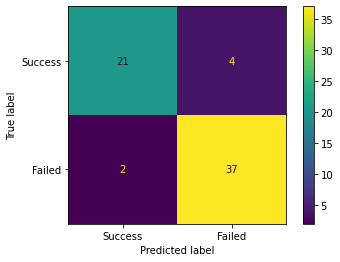

In [60]:
# Plot a confusion matrix
fig, ax = plt.subplots(1,1, figsize=(8,8))

plot_confusion_matrix(model, X_val, y_val,
                      display_labels=['Success', 'Failed'],
                      )
fig.clf()

In [62]:
# See our precision and recall
y_pred = model.predict(X_val)
print (metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

      Failed       0.91      0.84      0.87        25
     Success       0.90      0.95      0.92        39

    accuracy                           0.91        64
   macro avg       0.91      0.89      0.90        64
weighted avg       0.91      0.91      0.91        64



Pretty good! This model does a great job at predicting failed startups correctly and predicting successful startups correctly. Now, let's try doing it with a tree-based model, and see how our performance differs. 

In [69]:
# Make the pipeline
model_t = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier()
)

In [71]:
model_t.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['year of founding',
                                      'Focus functions of company',
                                      'Has the team size grown',
                                      'Est. Founding Date',
                                      'Country of company',
                                      'Number of Investors in Seed',
                                      'Number of Investors in Angel and or VC',
                                      'Presence of a top angel or venture fund '
                                      'in previous round of investment',
                                      'Number of of repeat investors',
                                      'Number of  Sales Support materia...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytre

In [72]:
# First we'll look at the training accuracy
print("Model's accuracy on training data: ", model_t.score(X_train, y_train))
# Now, we'll see our valiation accuracy
print("Model's accuracy on training data: ", model_t.score(X_val, y_val))

Model's accuracy on training data:  1.0
Model's accuracy on training data:  0.90625


<Figure size 576x576 with 0 Axes>

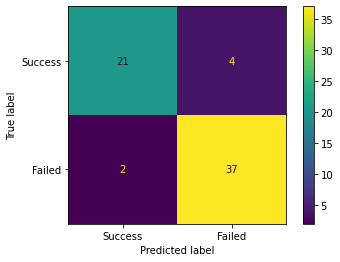

In [73]:
# Plot a confusion matrix
fig, ax = plt.subplots(1,1, figsize=(8,8))

plot_confusion_matrix(model_t, X_val, y_val,
                      display_labels=['Success', 'Failed'],
                      )
fig.clf()

In [76]:
# See our precision and recall
y_pred_t = model_t.predict(X_val)
print (metrics.classification_report(y_val, y_pred_t))

              precision    recall  f1-score   support

      Failed       0.91      0.84      0.87        25
     Success       0.90      0.95      0.92        39

    accuracy                           0.91        64
   macro avg       0.91      0.89      0.90        64
weighted avg       0.91      0.91      0.91        64



Both seem to perform relatively equally. This is most likely due to the small size of the validation data, which we had to operate due to the small amount of observations we had. A good fix for this is to try k-fold cross validation, as that might give us better results.

First, we'll do our linear model

In [83]:
# Instantiate the k-fold cross-validation 
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=11)

# Fit the model using k-fold cross-validation
cv_scores = cross_val_score(model, X_train_l, y_train_l,
                           cv=kfold_cv)

# Print the mean score
print('All cv scores: ', cv_scores)

# Print the mean score
print('Mean of all cv scores: ', cv_scores.mean())

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: Future

All cv scores:  [0.89411765 0.87058824 0.81176471 0.85882353 0.86904762]
Mean of all cv scores:  0.8608683473389356


Now our XGBoost model

In [84]:
# Instantiate the k-fold cross-validation 
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=11)

# Fit the model using k-fold cross-validation
cv_scores = cross_val_score(model_t, X_train_l, y_train_l,
                           cv=kfold_cv)

# Print the mean score
print('All cv scores: ', cv_scores)

# Print the mean score
print('Mean of all cv scores: ', cv_scores.mean())

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: Future

All cv scores:  [0.91764706 0.87058824 0.89411765 0.91764706 0.94047619]
Mean of all cv scores:  0.9080952380952381


Great! By using K-fold cross validation, we can see our xgboost model performs far better!

Now, let's select that model, and see how it performs against the test data.



In [85]:
model_t.fit(X_train_l, y_train_l)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['year of founding',
                                      'Focus functions of company',
                                      'Has the team size grown',
                                      'Est. Founding Date',
                                      'Country of company',
                                      'Number of Investors in Seed',
                                      'Number of Investors in Angel and or VC',
                                      'Presence of a top angel or venture fund '
                                      'in previous round of investment',
                                      'Number of of repeat investors',
                                      'Number of  Sales Support materia...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytre

In [86]:
# First we'll look at the training accuracy
print("Model's accuracy on training data: ", model_t.score(X_train_l, y_train_l))
# Now, we'll see our valiation accuracy
print("Model's accuracy on training data: ", model_t.score(X_test, y_test))

Model's accuracy on training data:  1.0
Model's accuracy on training data:  0.9375


<Figure size 576x576 with 0 Axes>

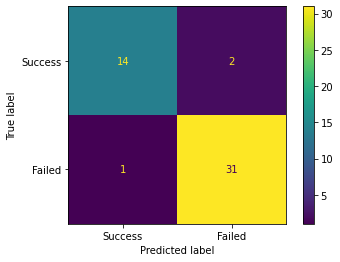

In [87]:
# Plot a confusion matrix
fig, ax = plt.subplots(1,1, figsize=(8,8))

plot_confusion_matrix(model_t, X_test, y_test,
                      display_labels=['Success', 'Failed'],
                      )
fig.clf()

In [89]:
# See our precision and recall
y_pred_t = model_t.predict(X_test)
print (metrics.classification_report(y_test, y_pred_t))

              precision    recall  f1-score   support

      Failed       0.93      0.88      0.90        16
     Success       0.94      0.97      0.95        32

    accuracy                           0.94        48
   macro avg       0.94      0.92      0.93        48
weighted avg       0.94      0.94      0.94        48



Good stats! We'll be using this model for our web app, as it's doing a great job at predicting the startups!